# Project Description# 

This project is the final project for the "How to win a data science competition" Coursera course.

This project is provided with a challenging time-series dataset consisting of historical daily sales data. The task is to predict total sales for every product sold in every store in the next month. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

# Project Pipeline

* load data
* remove outliers and handle abnormal values
* handle data leakage to avoid over-generalization
* engineer new features, such as revenue, lagged features, rolling stats, et cetera
* explore data trend and visualize
* re-structure data to fit into models
* prepare train/validation/test datasets
* set model performance evaluators
* explore different ways to forecast timeseries data:
*     1. AR/MA models
*     2. LSTM model
*     3. Ensemble method (with Linear regression/XGBoost/Random Forest models)

# **Data extract and preprocessing**

In [112]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pylab

pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 10)

In [113]:
sales_train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
item_cat = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
test_sub = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')
sample_sub = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv')

**Handle outliers and abnormal values**

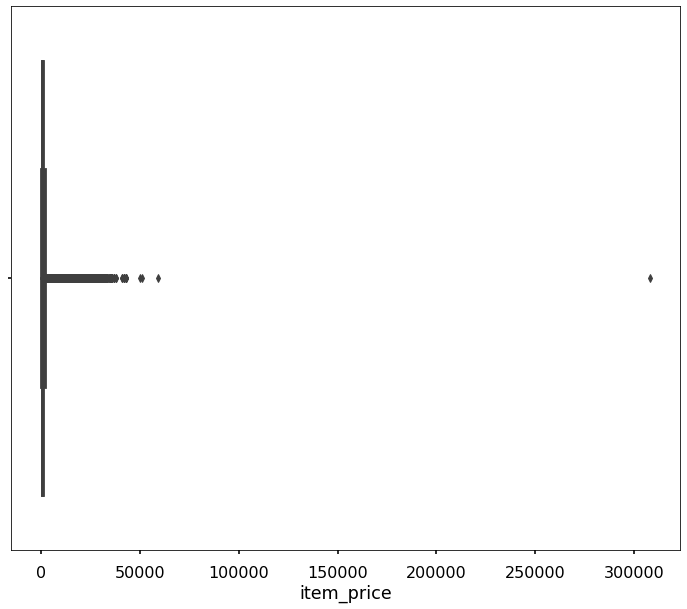

In [114]:
# check if there are outliers
sns.boxplot(x='item_price',data=sales_train)
sales_train = sales_train[sales_train['item_price']<10000]

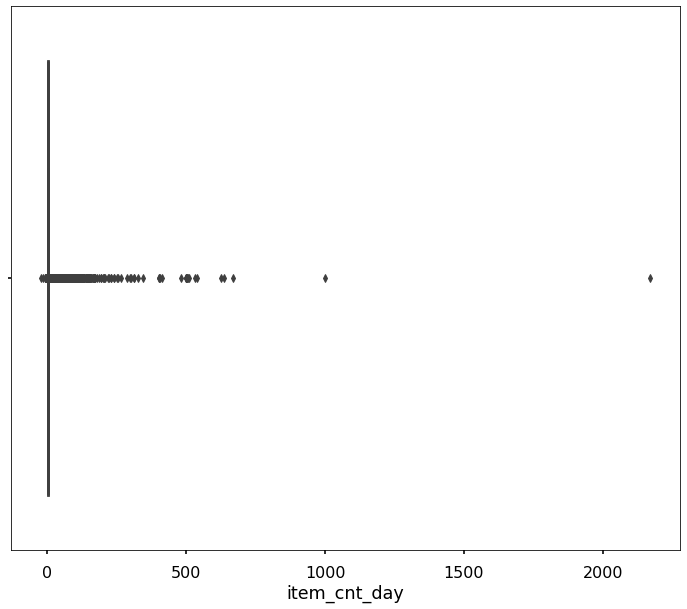

In [115]:
sns.boxplot(x='item_cnt_day',data=sales_train)
sales_train = sales_train[sales_train['item_cnt_day']<1000]

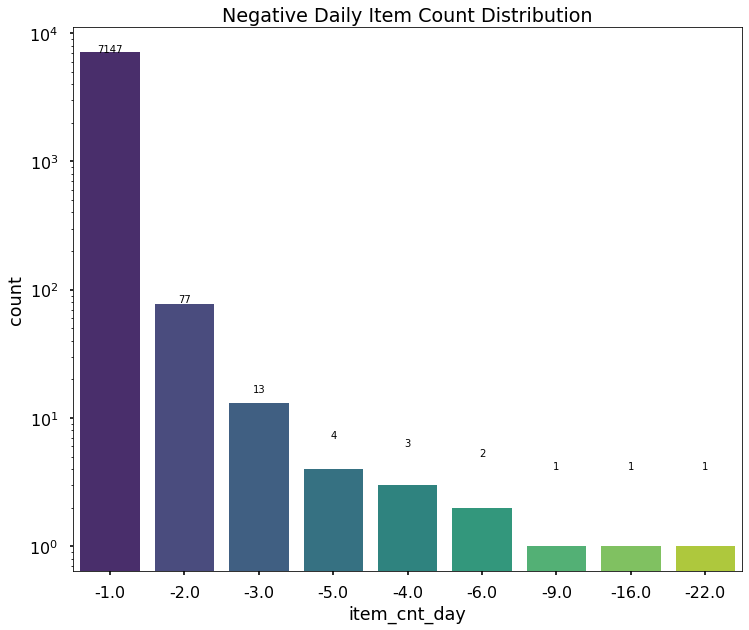

In [116]:
# it looks there are negative numbers in column item_cnt_day, let's take a look
negative_cnt = sales_train[sales_train['item_cnt_day']<0].sort_values(by='item_cnt_day',ascending=True)
g = sns.countplot(x=negative_cnt['item_cnt_day'],palette='viridis',order=negative_cnt["item_cnt_day"].value_counts().index)#[negative_cnt['item_cnt_day']<-1])
g.set(yscale='log')
plt.title('Negative Daily Item Count Distribution')
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.0f}'.format(height),
            ha="center")

There are more than 7k data entries with negative daily item count. In the project this data field is described as "number of products sold". Does a negative number indicate a return&refund?
It's not clear what's the meaning of negative numbers in item_cnt_day yet. For now let's treat it as outliers and remove it from the dataset.

In [117]:
sales_train = sales_train[sales_train['item_cnt_day']>0]

In [118]:
# let's check if there are negative values in the item_price column
print(sales_train[sales_train['item_price']<0])
# we can see there is one item with negative price. Let's fill it with median price of all the other items with the same item_id from the same shop on the same day (or in the same month if there is no other items sold from the same day)
m = sales_train[(sales_train['shop_id']==32)&(sales_train['item_id']==2973)&(sales_train['date_block_num']==4)&(sales_train['item_price']>0)]['item_price'].median()
sales_train.loc[sales_train['item_price']<0,'item_price'] = m

              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683  15.05.2013               4       32     2973        -1.0           1.0


In [119]:
# now sales_train data is in good shape, let's look at the data from the other files. I don't understand Russian, but there are a few name fields that show similar strings, let's manually handle these given the small data size
dup_shop = shops.loc[shops['shop_id'].isin([0,1,10,11,57,58])]
print(dup_shop['shop_name']) #so we can see 0/57, 1/58, 10/11 are dups

sales_train.loc[sales_train['shop_id']==0,'shop_id']=57
test_sub.loc[test_sub['shop_id']==0,'shop_id']=57
sales_train.loc[sales_train['shop_id']==1,'shop_id']=58
test_sub.loc[test_sub['shop_id']==1,'shop_id']=58
sales_train.loc[sales_train['shop_id']==10,'shop_id']=11
test_sub.loc[test_sub['shop_id']==10,'shop_id']=11

0     !Якутск Орджоникидзе, 56 фран
1     !Якутск ТЦ "Центральный" фран
10       Жуковский ул. Чкалова 39м?
11       Жуковский ул. Чкалова 39м²
57          Якутск Орджоникидзе, 56
58          Якутск ТЦ "Центральный"
Name: shop_name, dtype: object


In [120]:
# item_cat data looks fine. Let's look at items data.
items_40 = items[items['item_category_id']==40]
items_40.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40


Most of items data looks fine, though it looks some of the items name contain special character, we don't know if the special characters are legit part of item names, or errors. 
As I won't do anyting with text features (also I don't understand the Russian text in this case), for now I will leave it as is.

In [121]:
# now that individual tables are handled, let's merge them together. since we don't need the descriptive features (shop name, item name, etc), we only need to join table items to sales_train, so that sales_train can have item_category_id info
sales_train = sales_train.join(items,on='item_id',rsuffix='_').drop(['item_id_','item_name'],axis=1)
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56
5,10.01.2013,0,25,2564,349.00,1.0,59


**Data leakage**

We want to eliminate the issue of over-generalization, as there are some shops/items that appear in trainset but didn't appear in testset. We want the model to only focus on shops/items that are included in the testdata.


In [122]:
test_shop_ids = test_sub['shop_id'].unique()
test_item_ids = test_sub['item_id'].unique()
# Only shops that exist in test set.
sales_train_lk = sales_train[sales_train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
sales_train_lk = sales_train_lk[sales_train_lk['item_id'].isin(test_item_ids)]
print('train set size before leaking:',sales_train.shape)
print('train set size after leaking:',sales_train_lk.shape)

train set size before leaking: (2908853, 7)
train set size after leaking: (1217835, 7)


# **Feature generation**

In [123]:
# let's convert the date column to the right format
sales_train_lk['date'] = sales_train_lk['date'].apply(lambda x: datetime.datetime.strptime(x,'%d.%m.%Y'))

In [124]:
# add a revenue feature
sales_train_lk['revenue'] = sales_train_lk['item_price']*sales_train_lk['item_cnt_day']

In [125]:
monthly_train_lk = sales_train_lk.groupby(['date_block_num','shop_id','item_category_id','item_id'],as_index=False)#['date','item_cnt_day','item_price'].agg({'date':['min','max'],'item_cnt_day':'sum','item_price':'mean'}).reset_index()
monthly_train_lk = monthly_train_lk.agg({'item_price':['sum','mean'],
                                         'item_cnt_day':['sum','mean','count'],
                                         'revenue':['sum','mean']})
monthly_train_lk.head()

date_block_num shop_id item_category_id item_id item_price  ... item_cnt_day                  revenue             
                                                         sum  ...          sum      mean count      sum         mean
0              0       2                2    5572    10730.0  ...          9.0  1.285714     7  13910.0  1987.142857
1              0       2                2    5643     2390.0  ...          1.0  1.000000     1   2390.0  2390.000000
2              0       2                5    5583     1188.3  ...          2.0  1.000000     2   1188.3   594.150000
3              0       2                6    7893     5970.0  ...          3.0  1.000000     3   5970.0  1990.000000
4              0       2                6    7894     1490.0  ...          1.0  1.000000     1   1490.0  1490.000000

[5 rows x 11 columns]

In [126]:
# rename features
monthly_train_lk.columns = ['date_block_num','shop_id','item_category_id','item_id','total_item_price','avg_item_price','total_item_cnt','avg_item_cnt','total_txn_cnt','total_revenue','avg_revenue']

In [127]:
monthly_train_lk.shape

(599239, 11)

There are about 6k records with total_item_cnt>20, about 1% of the total data size, I will treat these as outliers and remove these records from the dataset.

In [128]:
monthly_train_lk = monthly_train_lk[monthly_train_lk['total_item_cnt']<=20]

In [129]:
monthly_train_lk.shape

(593256, 11)

Create placeholder for the missing records of combination of date_block_num, shop_id and item_id

In [130]:
# build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing shop_id or item_id that exist in testdata but not in traindata.
train_shop_ids = monthly_train_lk['shop_id'].unique()
train_item_ids = monthly_train_lk['item_id'].unique()
temp_df = []
for i in range(len(monthly_train_lk['date_block_num'].unique())):
    for shop in train_shop_ids:
        for item in train_item_ids:
            temp_df.append([i,shop,item])
temp_df = pd.DataFrame(temp_df,columns=['date_block_num','shop_id','item_id'])
print(temp_df.shape)

(6693036, 3)


In [131]:
# merge the placeholder set with the train dataset, and fill missing recodes with 0
monthly_train_lk = pd.merge(temp_df,monthly_train_lk,on=['date_block_num','shop_id','item_id'],how='left')
monthly_train_lk.fillna(0,inplace=True)
print(monthly_train_lk.shape)

(6693036, 11)


In [132]:
# let's generate two more columns based on date_block_num: month and year
monthly_train_lk['month'] = monthly_train_lk['date_block_num'].apply(lambda x: ((x%12)+1))
monthly_train_lk['year'] = monthly_train_lk['date_block_num'].apply(lambda x: ((x//12)+2013))

In [133]:
# unitary item price
# monthly_train_lk.columns = ['date_block_num','shop_id','item_category_id','item_id','total_item_price','avg_item_price','total_item_cnt','avg_item_cnt','total_txn_cnt','total_revenue','avg_revenue']
monthly_train_lk['unit_item_price'] = monthly_train_lk['total_revenue']//monthly_train_lk['total_item_cnt']
monthly_train_lk['unit_item_price'].fillna(0,inplace=True)
monthly_train_lk[np.isinf(monthly_train_lk)] = 0

In [23]:
# min and max of unitary item price over the whole sales period
minmax_price = monthly_train_lk.groupby(['item_id'],as_index=False).agg({'unit_item_price':[np.min,np.max]})
minmax_price.columns = ['item_id','min_unit_item_price','max_unit_item_price']
monthly_train_lk = pd.merge(monthly_train_lk,minmax_price,on='item_id',how='left')

In [24]:
# unit price change compared to min and max unitary price
monthly_train_lk['price_change+'] = monthly_train_lk['unit_item_price'] - monthly_train_lk['min_unit_item_price']
monthly_train_lk['price_change-'] = monthly_train_lk['max_unit_item_price'] - monthly_train_lk['unit_item_price']

In [25]:
# lagged features
lags = [1,2,3,6,12]
for lag in lags:
    col = ('total_item_cnt_lag_%s' % lag)
    monthly_train_lk[col] = monthly_train_lk.sort_values('date_block_num').groupby(['shop_id','item_category_id','item_id'])['total_item_cnt'].shift(lag)
    monthly_train_lk[col].fillna(0,inplace=True)

In [26]:
# item sale trend based on lagged features
monthly_train_lk['trend'] = monthly_train_lk['total_item_cnt']
for lag in lags:
    col = ('total_item_cnt_lag_%s' % lag)
    monthly_train_lk['trend'] -= monthly_train_lk[col]
monthly_train_lk['trend'] /= (len(lags)+1)

In [27]:
# rolling window based features off total_item_cnt
# define features
cnt_min = lambda x: x.rolling(window=3,min_periods=1).min()
cnt_max = lambda x: x.rolling(window=3,min_periods=1).max()
cnt_avg = lambda x: x.rolling(window=3,min_periods=1).mean()
cnt_std = lambda x: x.rolling(window=3,min_periods=1).std()
func_list = [cnt_min,cnt_max,cnt_avg,cnt_std]
func_name = ['rolling_min','rolling_max','rolling_avg','rolling_std']

for i in range(len(func_list)):
    monthly_train_lk[('total_item_cnt_%s'%func_name[i])] = monthly_train_lk.sort_values('date_block_num').groupby(['shop_id','item_category_id','item_id'])['total_item_cnt'].apply(func_list[i])

monthly_train_lk['total_item_cnt_rolling_std'].fillna(0,inplace=True)

In [28]:
# create the final prediction feature 'item_cnt_next_month'
monthly_train_lk['item_cnt_next_month'] = monthly_train_lk.sort_values('date_block_num').groupby(['shop_id','item_id'])['total_item_cnt'].shift(-1)

In [29]:
# take a look at the data with all features generated
monthly_train_lk.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.0,0.000000
shop_id,2.000000,2.000000,2.000000,2.0,2.000000
item_id,5572.000000,5643.000000,5583.000000,7893.0,7894.000000
item_category_id,2.000000,2.000000,5.000000,6.0,6.000000
total_item_price,10730.000000,2390.000000,1188.300000,5970.0,1490.000000
avg_item_price,1532.857143,2390.000000,594.150000,1990.0,1490.000000
total_item_cnt,9.000000,1.000000,2.000000,3.0,1.000000
avg_item_cnt,1.285714,1.000000,1.000000,1.0,1.000000
total_txn_cnt,7.000000,1.000000,2.000000,3.0,1.000000
total_revenue,13910.000000,2390.000000,1188.300000,5970.0,1490.000000


# Exploratory data analysis

In [30]:
monthly_train_lk.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6693036.0,16.500000,9.810709,0.000000,8.0,16.5,25.0,33.000000
shop_id,6693036.0,31.666667,17.533190,2.000000,16.0,34.5,47.0,59.000000
item_id,6693036.0,11048.534457,6218.923988,30.000000,5380.0,11255.0,16083.0,22167.000000
item_category_id,6693036.0,3.777641,13.202267,0.000000,0.0,0.0,0.0,83.000000
total_item_price,6693036.0,152.046449,1038.744953,0.000000,0.0,0.0,0.0,79992.000000
avg_item_price,6693036.0,73.719502,359.998510,0.000000,0.0,0.0,0.0,9999.000000
total_item_cnt,6693036.0,0.185968,0.907970,0.000000,0.0,0.0,0.0,20.000000
avg_item_cnt,6693036.0,0.093887,0.313078,0.000000,0.0,0.0,0.0,20.000000
total_txn_cnt,6693036.0,0.167711,0.741244,0.000000,0.0,0.0,0.0,19.000000
total_revenue,6693036.0,172.834481,1353.525606,0.000000,0.0,0.0,0.0,169983.000000


In [31]:
# let's first look at overall monthly sales data
month_sum = monthly_train_lk.groupby(['date_block_num','year','month'],as_index=False)['total_item_cnt'].sum()
month_sum_pivot = month_sum.pivot(values='total_item_cnt',columns='year',index='month')

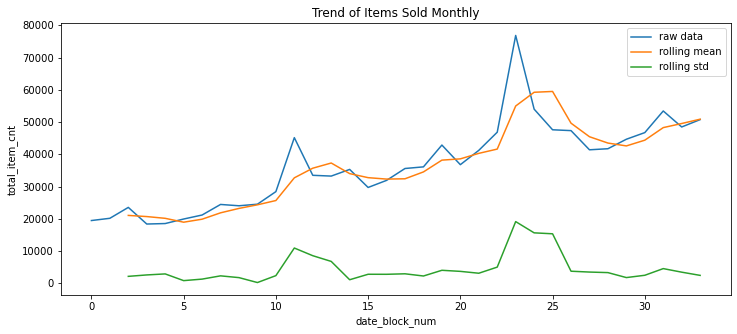

In [32]:
plt.figure(figsize=(12,5))
sns.lineplot(x='date_block_num',y='total_item_cnt',data=month_sum,label='raw data')
plt.plot(month_sum['total_item_cnt'].rolling(window=3,center=False).mean(),label='rolling mean')
plt.plot(month_sum['total_item_cnt'].rolling(window=3,center=False).std(),label='rolling std')
plt.title('Trend of Items Sold Monthly')
plt.legend()

It looks there is a year-over-year upward trend with obvious spike by the end of each year. Let's take a closer look by breaking down data into each years and compare YOY.

Text(0.5, 1.0, 'Monthly Sales by Year (2013-2015)')

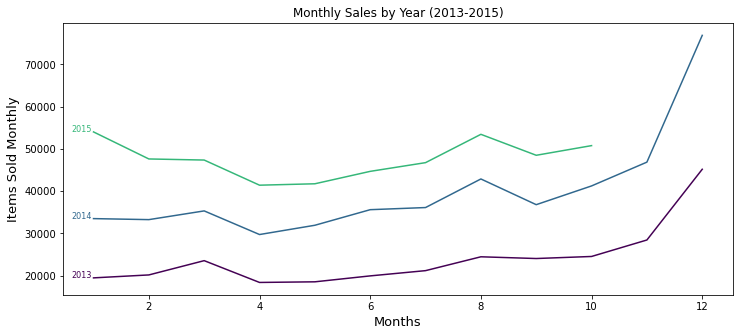

In [33]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot()
colors = [plt.cm.viridis(i/float(len(month_sum_pivot.columns))) for i in range(len(month_sum_pivot.columns))]
x = month_sum_pivot.index
for col,color in zip(month_sum_pivot.columns,colors):
    y = month_sum_pivot[col]
    ax.plot(x,y,label=col,c=color)
    x_annotate = x[0]
    y_annotate = month_sum_pivot.iloc[0][col]
    ax.text(x_annotate-0.4,y_annotate,col,fontsize=8,c=color)
ax.set_xlabel('Months', fontsize = 13)
ax.set_ylabel('Items Sold Monthly', fontsize = 13)
ax.set_title('Monthly Sales by Year (2013-2015)')

There is an upward trend year over year: 2014 on average is better than 2013, and 2015 better than 2014. And at the end of each year there is an obvious spike of sales.

Text(0.5, 1.0, 'Trend of Monthly Revenue')

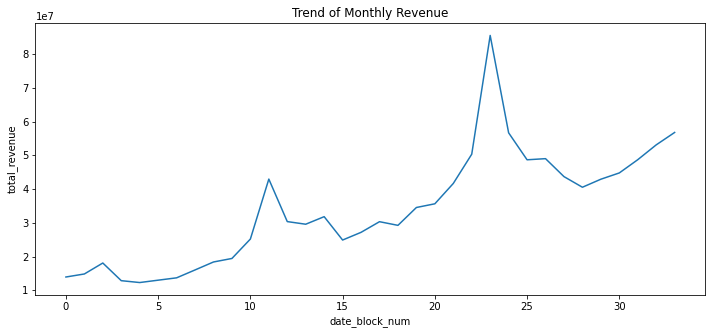

In [34]:
# let's look at trend of revenue
month_revenue = monthly_train_lk.groupby(['date_block_num','year','month'],as_index=False)['total_revenue'].sum()

plt.figure(figsize=(12,5))
sns.lineplot(x='date_block_num',y='total_revenue',data=month_revenue).set_title('Trend of Monthly Revenue')

Revenue shows the similar trend as items sold.

    item_category_id  total_item_cnt
15              55.0        177966.0
8               30.0        171344.0
12              40.0        141547.0
3               19.0         90469.0
6               23.0         82683.0


Text(0.5, 1.0, 'Monthly Sales by Categories')

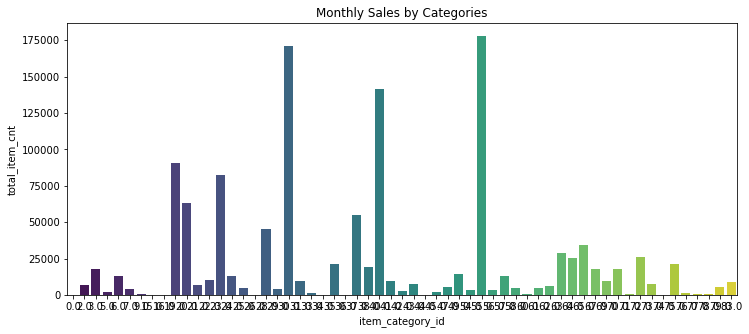

In [35]:
# let's then look at sales data at category level
category_sum = monthly_train_lk.groupby(['item_category_id'],sort=False)['total_item_cnt'].agg([('total_item_cnt','sum')]).reset_index().sort_values(by='total_item_cnt',ascending=False)
#category_sum = category_sum.sort_values(by='total_item_cnt',ascending=False)
print(category_sum.head())
plt.figure(figsize=(12,5))
sns.barplot(x='item_category_id',y='total_item_cnt',data=category_sum,palette='viridis').set_title('Monthly Sales by Categories')

    item_category_id  total_revenue
45              20.0   1.752672e+08
3               19.0   1.406220e+08
6               23.0   1.169041e+08
8               30.0   9.508417e+07
15              55.0   5.334223e+07


Text(0.5, 1.0, 'Monthly Revenue by Categories')

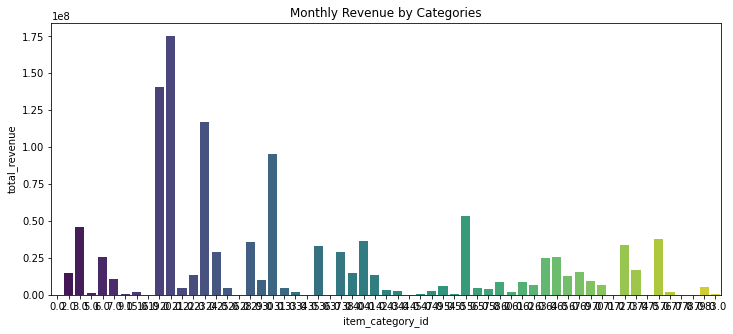

In [36]:
category_rev_sum = monthly_train_lk.groupby(['item_category_id'],sort=False)['total_revenue'].agg([('total_revenue','sum')]).reset_index().sort_values(by='total_revenue',ascending=False)
print(category_rev_sum.head())
plt.figure(figsize=(12,5))
sns.barplot(x='item_category_id',y='total_revenue',data=category_rev_sum,palette='viridis').set_title('Monthly Revenue by Categories')

Looks a few number of categories take up a large portion of the total sell count. Yet top revenue contributors are not necessarily the most popular categories.

   shop_id  total_item_cnt
0        2         15772.0
1        3         14995.0
2        4         20220.0
3        5         21264.0
4        6         39615.0


Text(0.5, 1.0, 'Monthly Sales by Shops')

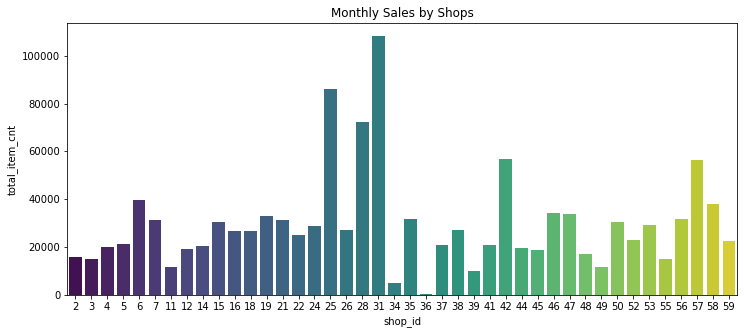

In [37]:
shop_mean = monthly_train_lk.groupby(['shop_id'],as_index=False)['total_item_cnt'].mean()
shop_sum = monthly_train_lk.groupby(['shop_id'],as_index=False)['total_item_cnt'].sum()
print(shop_sum.head())
plt.figure(figsize=(12,5))
sns.barplot(x='shop_id',y='total_item_cnt',data=shop_sum,palette='viridis').set_title('Monthly Sales by Shops')

   shop_id  total_revenue
0        2    20247335.16
1        3    15954572.81
2        4    18340819.40
3        5    19016440.80
4        6    36303299.48


Text(0.5, 1.0, 'Monthly Revenue by Shops')

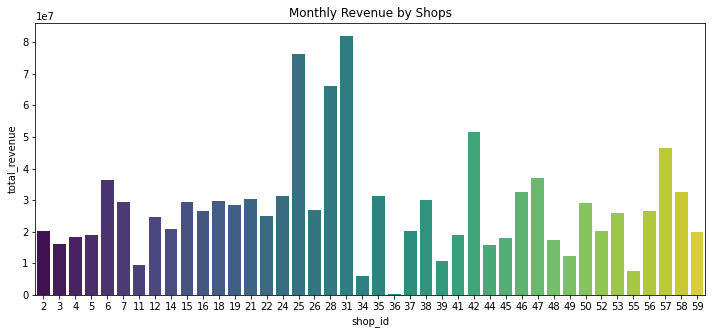

In [38]:
shop_rev_sum = monthly_train_lk.groupby(['shop_id'],as_index=False)['total_revenue'].sum()
print(shop_rev_sum.head())
plt.figure(figsize=(12,5))
sns.barplot(x='shop_id',y='total_revenue',data=shop_rev_sum,palette='viridis').set_title('Monthly Revenue by Shops')

Most shops have a similar sell count. And shops that sell the most number of items are also top revenue contributors.

In [157]:
del sales_train
del items
del item_cat
del shops
del negative_cnt
del dup_shop
del items_40
del test_shop_ids
del test_item_ids
del train_shop_ids
del train_item_ids
del temp_df
del month_sum
del month_sum_pivot
del month_revenue
del category_sum
del category_rev_sum
del shop_mean
del shop_sum
del shop_rev_sum

import gc 
gc.collect();

NameError: name 'month_sum' is not defined

# Modeling and prediction

**Define a performance evaluation visualization function**

In [134]:
# define a performance evaluation function and visualize the performance of different models
# The closer the points are to the middle dashed line the better are the predictions.
from numpy.polynomial.polynomial import polyfit

def model_performance_sc_plot(predictions,labels,title):
    min_val = max(max(predictions),max(labels))
    max_val = min(min(predictions),min(labels))
    performance = pd.DataFrame({'Label':labels,'Prediction':predictions})
    #performance = performance.astype(dtype={'Label':float,'Prediction':float})
    
    b, m = polyfit(performance['Prediction'], performance['Label'], 1)
    # plot the data
    plt.figure(figsize=(8,6))
    plt.plot([min_val,max_val],[min_val,max_val],'m--')
    plt.plot(performance['Prediction'],performance['Label'],'.')
    plt.plot(performance['Prediction'],b+m*performance['Prediction'],'-')
    plt.title(title)

***Part I : ARIMA***

I start with ARIMA mmodels because it's simple to implement without any parameter tuning, and quick to run.

In [135]:
arima_data_df = monthly_train_lk.groupby(['date_block_num']).agg({'total_item_cnt':'sum'})
arima_data = list(arima_data_df['total_item_cnt'].values)

In [136]:
# perform dickey-fuller test to assess whether data is stationary
from statsmodels.tsa.stattools import adfuller
def stationary_test(data):
    #print('Is the data stationary ?')
    dftest = adfuller(data, autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Number of Observations = {:.0f}'.format(dftest[3]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k,v,'not' if v<dftest[0] else '',100-int(k[:-1])))
# let's run stationary test on raw data, de-trended data, and de-seasonalized data
print('Is the raw data stationary ?')
stationary_test(arima_data)

Is the raw data stationary ?
Test statistic = -1.949
P-value = 0.310
Number of Observations = 33
Critical values :
	1%: -3.6461350877925254 - The data is not stationary with 99% confidence
	5%: -2.954126991123355 - The data is not stationary with 95% confidence
	10%: -2.6159676124885216 - The data is not stationary with 90% confidence


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


Text(0.5, 1.0, 'AR model')

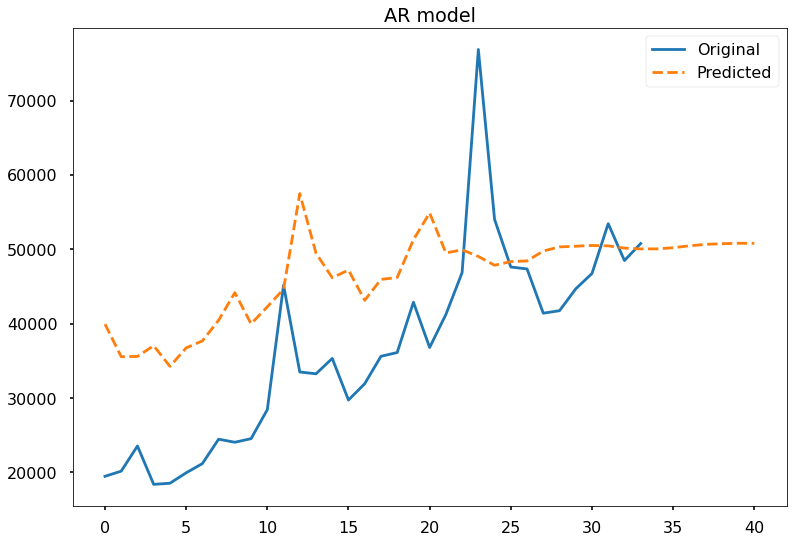

In [138]:
# AR model
from statsmodels.tsa.ar_model import AR
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

model = AR(arima_data)
ar_model = model.fit()
yhat = ar_model.predict(12,len(arima_data)+18)

dataList = list(arima_data)
yhatList = list(yhat)

plt.style.use('seaborn-poster')
plt.figure()
plt.plot(dataList,label='Original')
plt.plot(yhatList,ls='--',label='Predicted')
plt.legend(loc='best')
plt.title('AR model')

In [139]:
from sklearn.metrics import mean_squared_error

ar_rmse = np.sqrt(mean_squared_error(dataList,yhatList[0:34]))
print('AR RMSE: %.1f' % ar_rmse)

AR RMSE: 13424.8


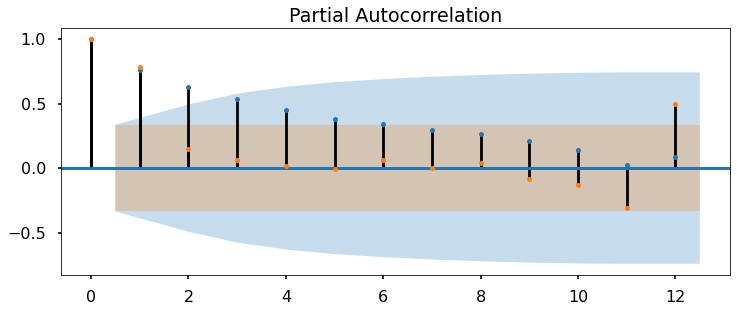

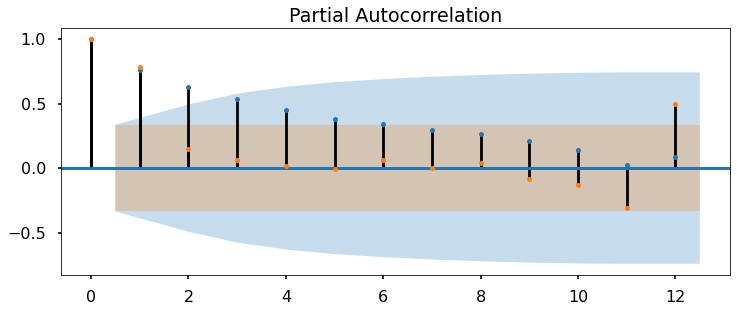

In [142]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.figure(figsize=(12,10))
ax = plt.subplot(211)
plot_acf(arima_data,lags=12,ax=ax)
plot_pacf(arima_data,lags=12,ax=ax)

In [154]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import statsmodels.api as sm
import itertools
best_aic = np.inf
best_order = None
best_order_seasonal = None
best_model = None
p = d = q = range(3)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]
output = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(arima_data,
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            results = model.fit()
            output.append('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
            temp_aic = results.aic
            if temp_aic<best_aic:
                best_aic = temp_aic
                best_order = param
                best_order_seasonal = param_seasonal
                best_model = results
        except:
            continue
print('aic: {:6.5f} | order: {} | seasonal order: {}'.format(best_aic,best_order,best_order_seasonal))
#aic: 4.00000 | order: (0, 0, 0) | seasonal order: (0, 2, 1, 12)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:901: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


aic: 4.00000 | order: (0, 0, 0) | seasonal order: (0, 2, 1, 12)


Text(0.5, 1.0, 'SARIMAX model')

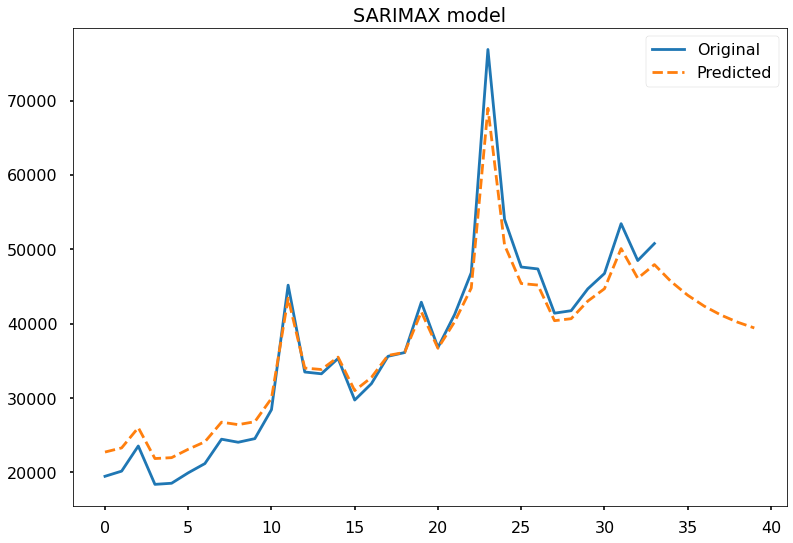

In [155]:
# SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(arima_data,
                order=(0,0,0),
                seasonal_order=(0,2,1,12),
                enforce_stationarity=False,
                enforce_invertibility=False)
sarima_model = model.fit(disp=False)
yhat = arima_model.predict(1,len(arima_data)+6)

dataList = list(arima_data)
yhatList = list(yhat)

plt.style.use('seaborn-poster')
plt.figure()
plt.plot(dataList,label='Original')
plt.plot(yhatList,ls='--',label='Predicted')
plt.legend(loc='best')
plt.title('SARIMAX model')

In [156]:
sarima_rmse = np.sqrt(mean_squared_error(dataList,yhatList[0:34]))
print('SARIMAX RMSE: %.1f' % sarima_rmse)

SARIMAX RMSE: 2534.4


Apparently the above AR/MA models couldn't deal with hirarchical data. And it's not efficient to run an AR/MA model going through every combination of item_id and shop_id. Next for fun, I will explore a new technique called FB prophet.

**FB Prophet**

In [52]:
fb_data = monthly_train_lk.groupby(['date_block_num'])['total_item_cnt'].sum()
fb_data.index = pd.date_range(start='2013-01-01',end='2015-10-01',freq='MS')
fb_data = fb_data.reset_index()
fb_data.head()

,index,total_item_cnt
0,2013-01-01,19487.0
1,2013-02-01,20182.0
2,2013-03-01,23561.0
3,2013-04-01,18404.0
4,2013-05-01,18553.0


In [53]:
from fbprophet import Prophet
fb_data.columns=['ds','y']
model = Prophet(yearly_seasonality=True)
model.fit(fb_data)

In [54]:
fb_data_ext = model.make_future_dataframe(periods=6,freq='MS')
forecast = model.predict(fb_data_ext)
forecast[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01,20048.664279,17399.846367,22618.833888
1,2013-02-01,20569.746807,17708.978965,23382.760852
2,2013-03-01,22653.405931,19698.028068,25492.402403
3,2013-04-01,16268.674493,13454.704790,19136.980520
4,2013-05-01,16446.586883,13545.289260,19402.744562
5,2013-06-01,18370.316252,15541.150671,21043.439258
6,2013-07-01,19833.926595,17088.723481,22483.008153
7,2013-08-01,24726.665540,22025.079489,27503.418512
8,2013-09-01,24302.335700,21481.416265,27000.304518
9,2013-10-01,26789.015520,24004.803817,29472.673302


In [55]:
dataList = arima_data

Text(0.5, 1.0, 'FB Prophet model')

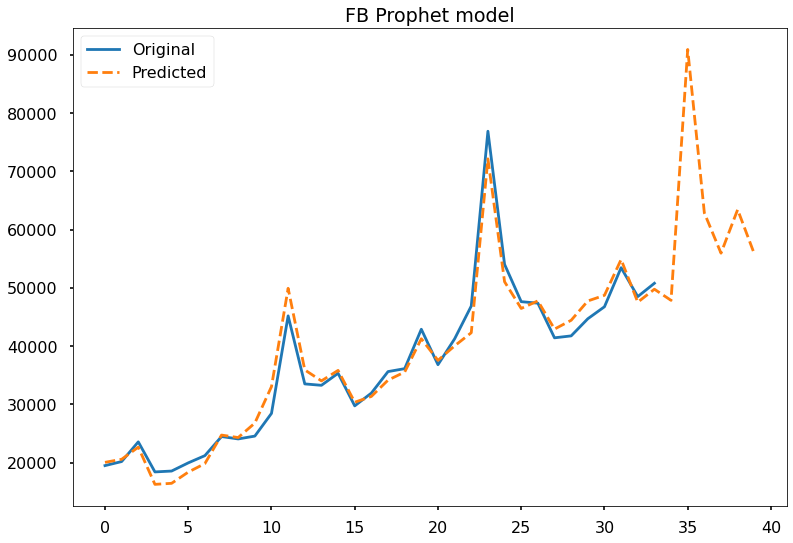

In [56]:
plt.style.use('seaborn-poster')
plt.figure()
plt.plot(dataList,label='Original')
plt.plot(forecast['yhat'],ls='--',label='Predicted')
plt.legend(loc='best')
plt.title('FB Prophet model')

In [57]:
fb_rmse = np.sqrt(mean_squared_error(dataList,forecast['yhat'][0:34]))
print('FB Prophet RMSE: %.1f' % fb_rmse)

FB Prophet RMSE: 2156.4


The FB prophet captures both the upward trend and the spike by the end of each year. But I didn't explore how to deal with hierarchical data thru this approach. For now I will leave it here, and move on to learn about other models that can deal with hierarchical data. 

In [58]:
del arima_data_df
del arima_data
del fb_data

gc.collect();

***Part II : LSTM***

This part I will explore the single layer LSTM model. Why LSTM? It doesn't need level shifts and can handle non-linear relation with massive (and potentially multivariate) data.

In [59]:
lstm_data = monthly_train_lk[['date_block_num','shop_id','item_id','total_item_cnt','item_cnt_next_month']]
lstm_data_series = lstm_data.pivot_table(index=['shop_id','item_id'],columns='date_block_num',values='total_item_cnt',fill_value=0).reset_index()
lstm_data_series.head()

date_block_num,shop_id,item_id,0,1,2,...,29,30,31,32,33
0,2,30,0,0,1,...,0,0,0,0,0
1,2,31,0,4,1,...,0,0,0,0,1
2,2,32,0,0,0,...,0,0,1,0,0
3,2,33,1,0,0,...,0,1,0,1,0
4,2,38,0,0,0,...,0,0,0,0,0


In [60]:
lstm_data_series = pd.merge(test_sub,lstm_data_series,on=['item_id','shop_id'],how='left')
lstm_data_series.fillna(0,inplace=True)
lstm_data_series.drop(['shop_id','item_id'],inplace=True,axis=1)
lstm_data_series.head()

,0,1,2,3,4,...,29,30,31,32,33
0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0


**Prepare train/validation/test data**

In [61]:
# prepare X's and y's
# for X we will keep all columns execpt the last one 
X = np.expand_dims(lstm_data_series.values[:,:-1],axis=2)
# the last column is our label, ie. y
y = lstm_data_series.values[:,-1:]

In [62]:
# split train and validation among X's and y's
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=0)

print("Train set", X_train.shape)
print("Validation set", X_valid.shape)

Train set (192780, 33, 1)
Validation set (21420, 33, 1)


In [63]:
X_test = np.expand_dims(lstm_data_series.values[:,1:],axis=2)
print("Test set", X_test.shape)

Test set (214200, 33, 1)


**Train and predict with LSTM model**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


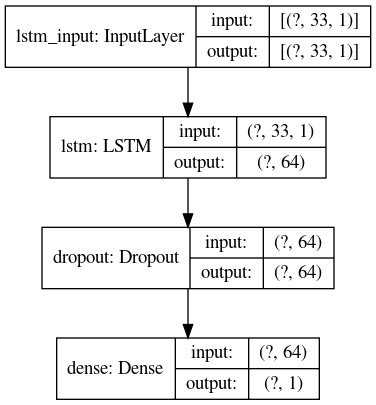

In [64]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras import optimizers
from keras.utils import plot_model

series_size = X_train.shape[1] # 12
n_feat = X_train.shape[2] # 1

epochs = 10
batch = 64
lr = 0.0001

lstm_model = Sequential()
lstm_model.add(LSTM(units = 64,input_shape = (series_size,n_feat)))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(1))
lstm_model.summary()

adam = optimizers.Adam(lr)
lstm_model.compile(loss='mse',optimizer=adam)
plot_model(lstm_model,show_shapes=True,to_file='regular_lstm.png')

In [65]:
lstm_model.fit(X_train,y_train,batch_size=batch,epochs=epochs,validation_data=(X_valid,y_valid),verbose=2)

Epoch 1/10
3013/3013 - 99s - loss: 0.6788 - val_loss: 0.6176
Epoch 2/10
3013/3013 - 101s - loss: 0.6454 - val_loss: 0.6110
Epoch 3/10
3013/3013 - 93s - loss: 0.6396 - val_loss: 0.6057
Epoch 4/10
3013/3013 - 92s - loss: 0.6377 - val_loss: 0.6023
Epoch 5/10
3013/3013 - 92s - loss: 0.6368 - val_loss: 0.6017
Epoch 6/10
3013/3013 - 92s - loss: 0.6367 - val_loss: 0.5991
Epoch 7/10
3013/3013 - 91s - loss: 0.6335 - val_loss: 0.5977
Epoch 8/10
3013/3013 - 91s - loss: 0.6334 - val_loss: 0.5963
Epoch 9/10
3013/3013 - 94s - loss: 0.6313 - val_loss: 0.5970
Epoch 10/10
3013/3013 - 92s - loss: 0.6314 - val_loss: 0.5966


**Evaluate model performance**

In [66]:
lstm_train_pred = lstm_model.predict(X_train)
lstm_val_pred = lstm_model.predict(X_valid)

print('Train RMSE:', np.sqrt(mean_squared_error(y_train, lstm_train_pred)))
print('Validation RMSE:', np.sqrt(mean_squared_error(y_valid, lstm_val_pred)))

Train RMSE: 0.7910624307927392
Validation RMSE: 0.7724205756324186


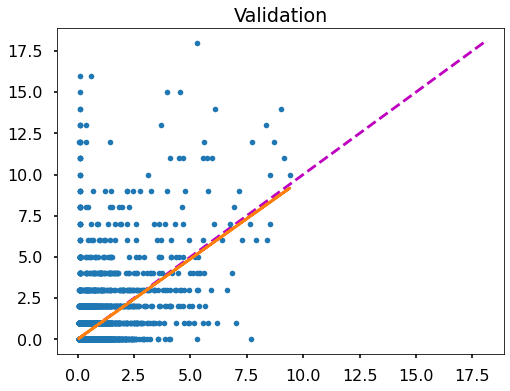

In [67]:
model_performance_sc_plot(lstm_val_pred.flatten(),y_valid.flatten(),'Validation')

In [68]:
lstm_pred = lstm_model.predict(X_test)

In [69]:
lstm_sub_df = pd.DataFrame(test_sub.index.values,columns=['ID'])
lstm_sub_df['item_cnt_next_month'] = lstm_pred.clip(0.,20.)
lstm_sub_df.to_csv('lstm_submission.csv',index=False)
lstm_sub_df.head(10)

,ID,item_cnt_next_month
0,0,0.500859
1,1,0.101765
2,2,0.780278
3,3,0.155522
4,4,0.101765
5,5,0.432376
6,6,1.025769
7,7,0.108187
8,8,1.136437
9,9,0.101765


The LSTM model prediction result looks good. Although I only implemented the basic LSTM model without further tuning the model hyper parameters. And the time series data can be truncated in better shape. For now I will leave it here and move on to ensembling method.

In [70]:
del lstm_data_series
del lstm_data

gc.collect();

***Part III : Ensemble learning***

This part I will try to ensemble several machine learning models with feature engineering techniques. It might be complicated than the two approaches earlier, though it allows the flexibility to add more features that might be helpful for prediction.

**Step 1: Train/validation/test split**

Previously we added lag6 and lag12 feature to the dataframe. After the first run of the selected models, it turns out that lag6 and lag12 features are not showing significant importance in the prediction. So next we will ignore lag6/lag12 features and re-split train/validation.

In [71]:
# there are 34 blocks from train and validation sets, we will ignore the first 3 blocks (0~2) as the first 3 blocks are used to generate windowned features
# then among the rest of the blocks available, we will split as following:
# train size = (3~27)
# validation size = (28-32) 
# test size = (33)
monthly_train_lk_new = monthly_train_lk.drop(['total_item_cnt_lag_6','total_item_cnt_lag_12'],axis=1)

train_set = monthly_train_lk_new[(monthly_train_lk['date_block_num']>=3) & (monthly_train_lk['date_block_num']<28)].copy()
validation_set = monthly_train_lk_new[(monthly_train_lk['date_block_num']>=28) & (monthly_train_lk['date_block_num']<33)].copy()
test_set = monthly_train_lk_new[monthly_train_lk['date_block_num']==33].copy()

In [72]:
# clean the nan values in the prediction label
train_set.dropna(subset=['item_cnt_next_month'],inplace=True)
validation_set.dropna(subset=['item_cnt_next_month'],inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/monthly_train_lk_new.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/monthly_train_lk_new.shape[0])*100)))

Train set records: 4921350
Validation set records: 984270
Test set records: 196854
Train set records: 4921350 (74% of complete data)
Validation set records: 984270 (15% of complete data)


In [73]:
del monthly_train_lk
del monthly_train_lk_new

gc.collect();

**Step 2 : Prepare train, validation and test set**

In [74]:
# create train and validation set labels
# we will also drop column item_category_id as it's not available in the test_sub data
X_train = train_set.drop(['date_block_num','item_cnt_next_month','item_category_id'],axis=1)
y_train = train_set['item_cnt_next_month'].astype(int)
X_validation = validation_set.drop(['date_block_num','item_cnt_next_month','item_category_id'],axis=1)
y_validation = validation_set['item_cnt_next_month'].astype(int)
#X_test = test_set.drop(['item_cnt_next_month'],axis=1)

In [75]:
# convert id and date related features to integer
int_feat = ['shop_id', 'item_id', 'year', 'month']

X_train[int_feat] = X_train[int_feat].astype(int)
X_validation[int_feat] = X_validation[int_feat].astype(int)

In [76]:
combo = pd.concat([train_set,validation_set]).drop_duplicates(subset=['shop_id','item_id'],keep='last')
X_test = pd.merge(test_sub,combo,on=['shop_id','item_id'],how='left',suffixes=['','_'])
X_test['year'] = 2015
X_test['month'] = 10
X_test.drop('item_cnt_next_month',axis=1,inplace=True)
X_test[int_feat] = X_test[int_feat].astype(int)
X_test = X_test[X_train.columns]

In [77]:
# check if there is null values in each X set
print(X_train.isnull().sum().sum())
print(X_validation.isnull().sum().sum())
print(X_test.isnull().sum().sum())

0
0
346920


In [78]:
# let's tackle the missing value issue in X_test
for item in X_test['item_id'].unique():
    for col in X_test.columns:
        item_median = X_test[(X_test['item_id']==item)][col].median()
        X_test.loc[(X_test[col].isnull()) & (X_test['item_id']==item),col] = item_median
        X_test.loc[np.isnan(X_test[col]) & (X_test['item_id']==item),col] = item_median
# if median isn't available for a certain item, calculate median based on items in the same shop
for shop in X_test['shop_id'].unique():
    for col in X_test.columns:
        shop_median = X_test[(X_test['shop_id']==shop)][col].median()
        X_test.loc[(X_test[col].isnull()) & (X_test['shop_id']==shop),col] = shop_median
        X_test.loc[np.isnan(X_test[col]) & (X_test['shop_id']==shop),col] = shop_median

#X_test.fillna(X_test.mean(), inplace=True)
X_test[int_feat] = X_test[int_feat].astype(int)

In [79]:
# double check if there is missing value issue left
print(X_train.isnull().sum().sum())
print(X_validation.isnull().sum().sum())
print(X_test.isnull().sum().sum())
print(np.isnan(X_train).sum().sum())
print(np.isnan(X_validation).sum().sum())
print(np.isnan(X_test).sum().sum())

print(y_train.isnull().sum())
print(y_validation.isnull().sum())
print(np.isnan(y_train).sum())
print(np.isnan(y_validation).sum())

0
0
0
0
0
0
0
0
0
0


**Step 3 : run individual models**

***Tree based models - XGBoost***

In [80]:
from xgboost import XGBRegressor
from xgboost import plot_importance

xgb_model = XGBRegressor(max_depth=8,
                        n_estimators=1000,
                        min_child_weight=300,
                        colsample_bytree=0.8,
                        subsample=0.8,
                        eta=0.3,
                        seed=42)
xgb_model.fit(X_train,y_train,
             eval_metric='rmse',
             eval_set=[(X_train,y_train),(X_validation,y_validation)],
             verbose=True,
             early_stopping_rounds=10)

[14:26:40] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:0.86374	validation_1-rmse:0.88872
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.80384	validation_1-rmse:0.83815
[2]	validation_0-rmse:0.77324	validation_1-rmse:0.81461
[3]	validation_0-rmse:0.75462	validation_1-rmse:0.80251
[4]	validation_0-rmse:0.74374	validation_1-rmse:0.79759
[5]	validation_0-rmse:0.73727	validation_1-rmse:0.79524
[6]	validation_0-rmse:0.73351	validation_1-rmse:0.79444
[7]	validation_0-rmse:0.73153	validation_1-rmse:0.79355
[8]	validation_0-rmse:0.72976	validation_1-rmse:0.79175
[9]	validation_0-rmse:0.72871	validation_1-rmse:0.79129
[10]	validation_0-rmse:0.72774	validation_1-rmse:0.79077
[11]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='approx', validate_parameters=1,
             verbosity=None)

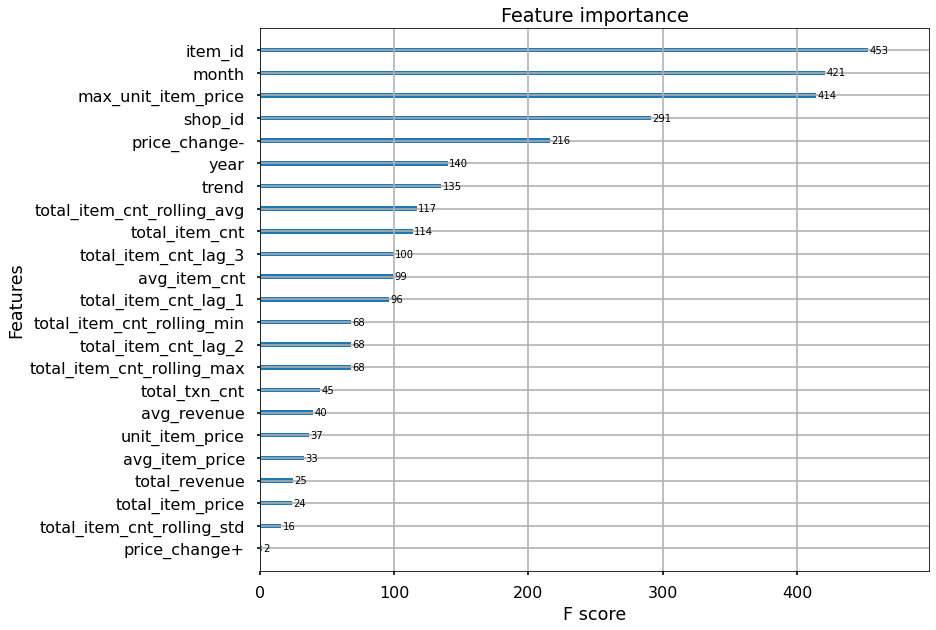

In [81]:
plt.rcParams['figure.figsize'] = (12,10)
plot_importance(xgb_model)

In [82]:
xgb_train_pred = xgb_model.predict(X_train)
xgb_val_pred = xgb_model.predict(X_validation)
xgb_test_pred = xgb_model.predict(X_test)

In [83]:
from sklearn.metrics import mean_squared_error

print('Train RMSE: ',np.sqrt(mean_squared_error(y_train,xgb_train_pred)))
print('Validation RMSE: ',np.sqrt(mean_squared_error(y_validation,xgb_val_pred)))

Train RMSE:  0.7241734570323274
Validation RMSE:  0.7895652245111866


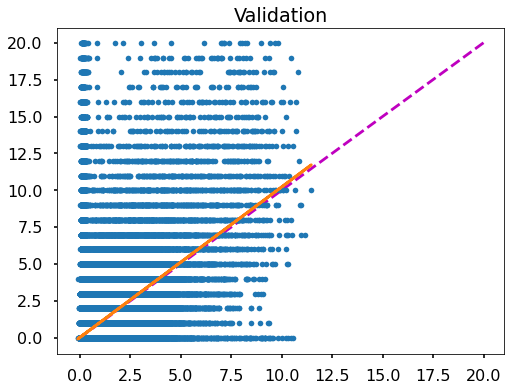

In [84]:
model_performance_sc_plot(xgb_val_pred,y_validation,'Validation')

***Tree based models - random forest***

In [85]:
# remove 0 importance features based on the first round model running
rf_feat = ['shop_id', 'item_id', 'total_item_price', 'avg_item_price', 'total_item_cnt', 'avg_item_cnt', 'total_txn_cnt', 'total_revenue', 'avg_revenue', 'month', 'year', 'max_unit_item_price', 'price_change-', 'total_item_cnt_lag_1', 'total_item_cnt_lag_2', 'total_item_cnt_lag_3', 'trend', 'total_item_cnt_rolling_min','total_item_cnt_rolling_max', 'total_item_cnt_rolling_avg']
rf_X_train = X_train[rf_feat]
rf_X_val = X_validation[rf_feat]
rf_X_test = X_test[rf_feat]

In [86]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=50,
                                max_depth=7,
                                random_state=0,
                                n_jobs=-1)
rf_model.fit(rf_X_train,y_train)

RandomForestRegressor(max_depth=7, n_estimators=50, n_jobs=-1, random_state=0)

In [87]:
print('Model params:', rf_model.get_params())

Model params: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


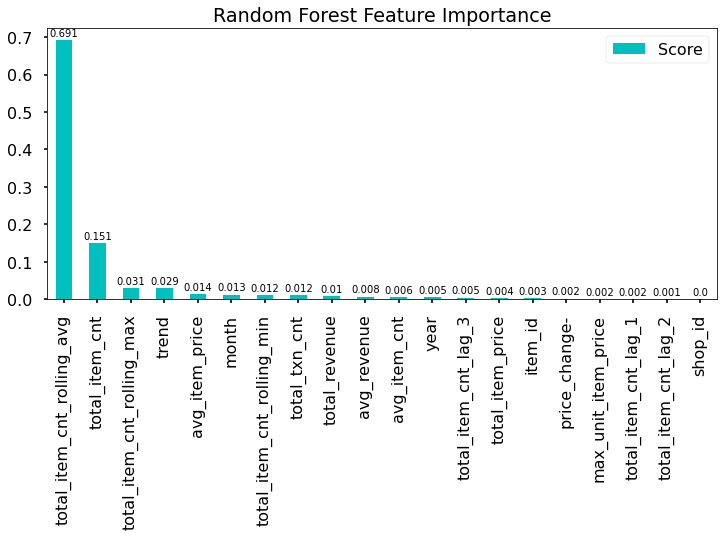

In [88]:
# get feature importance
feat_score = pd.DataFrame(list(zip(rf_X_train.dtypes.index,rf_model.feature_importances_)),columns=['Feature','Score'])
feat_score = feat_score.sort_values(by='Score',ascending=False,inplace=False,kind='quicksort',na_position='last')

plt.rcParams['figure.figsize'] = (12,5)
g = feat_score.plot('Feature','Score',kind='bar',color='c')
g.set_title('Random Forest Feature Importance')
g.set_xlabel('')

for patch,score in zip(g.patches,feat_score['Score'].round(3)):
    height = patch.get_height()
    g.text(patch.get_x()+patch.get_width()/2,
          height+0.01,
          score,
          ha='center')

In [89]:
rf_train_pred = rf_model.predict(rf_X_train)
rf_val_pred = rf_model.predict(rf_X_val)
rf_test_pred = rf_model.predict(rf_X_test)

In [90]:
print('Train RMSE: ',np.sqrt(mean_squared_error(y_train,rf_train_pred)))
print('Validation RMSE: ',np.sqrt(mean_squared_error(y_validation,rf_val_pred)))

Train RMSE:  0.7420080370878778
Validation RMSE:  0.7969225783040503


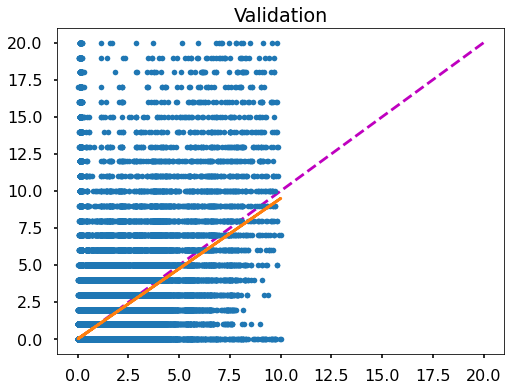

In [91]:
model_performance_sc_plot(rf_val_pred,y_validation,'Validation')

***Linear models - linear regression***

In [92]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

num_feat = ['total_item_price', 'avg_item_price', 'total_item_cnt', 'avg_item_cnt', 'total_txn_cnt', 'total_revenue', 'avg_revenue','unit_item_price', 'total_item_cnt_lag_1', 'total_item_cnt_lag_2', 'total_item_cnt_lag_3', 'trend','total_item_cnt_rolling_min', 'total_item_cnt_rolling_max', 'total_item_cnt_rolling_avg']
cat_feat = ['shop_id', 'item_id', 'month', 'year']
#X_train[int_feat] = X_train[int_feat].astype(int)

lr_scaler = MinMaxScaler()
lr_scaler.fit(X_train[num_feat])
lr_X_train = lr_scaler.transform(X_train[num_feat])
lr_X_val = lr_scaler.transform(X_validation[num_feat])
lr_X_test = lr_scaler.transform(X_test[num_feat])

In [93]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_X_train,y_train)

LinearRegression(n_jobs=-1)

Text(0.5, 0, '')

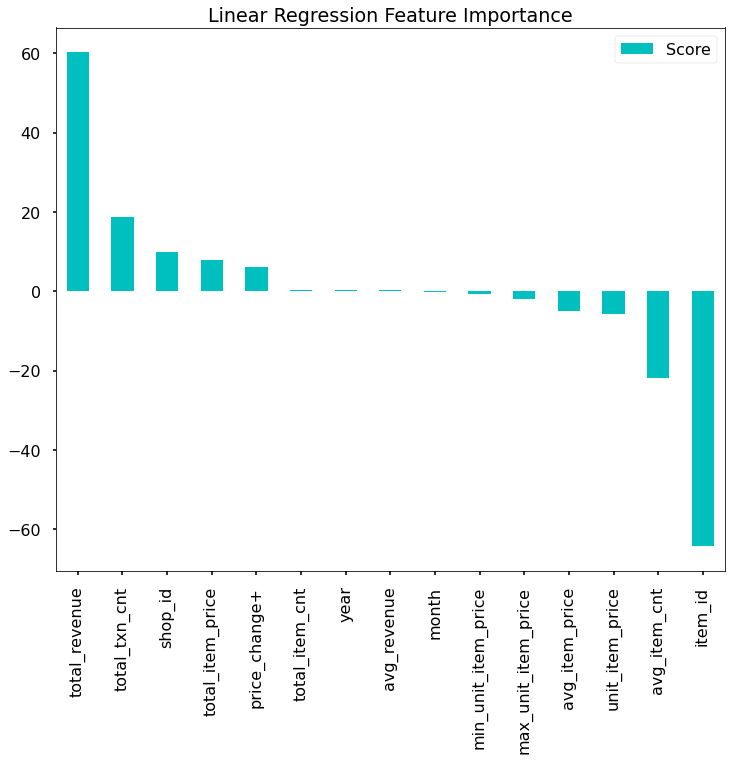

In [94]:
feat_score = pd.DataFrame(list(zip(X_train.dtypes.index,lr_model.coef_)),columns=['Feature','Score'])
feat_score = feat_score.sort_values(by='Score',ascending=False,inplace=False,kind='quicksort',na_position='last')

plt.rcParams['figure.figsize'] = (12,10)
g = feat_score.plot('Feature','Score',kind='bar',color='c')
g.set_title('Linear Regression Feature Importance')
g.set_xlabel('')

#for patch,score in zip(g.patches,feat_score['Score'].round(3)):
#    height = patch.get_height()
#    g.text(patch.get_x()+patch.get_width()/2,
#          height+5,
#          score,
#          ha='center')

In [95]:
lr_train_pred = lr_model.predict(lr_X_train)
lr_val_pred = lr_model.predict(lr_X_val)
lr_test_pred = lr_model.predict(lr_X_test)

In [96]:
print('Train RMSE: ',np.sqrt(mean_squared_error(y_train,lr_train_pred)))
print('Validation RMSE: ',np.sqrt(mean_squared_error(y_validation,lr_val_pred)))

Train RMSE:  0.750878544792629
Validation RMSE:  0.7997918124439407


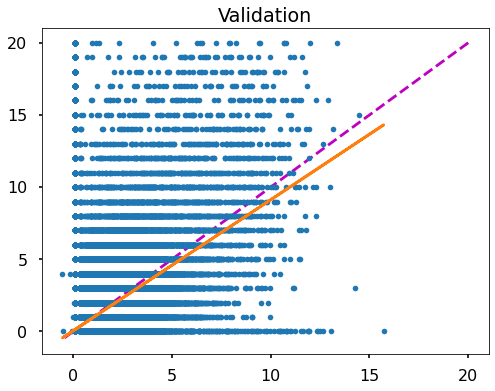

In [97]:
model_performance_sc_plot(lr_val_pred,y_validation,'Validation')

**Step 4: Model ensemble**

Combine predictions from all above models

In [98]:
# train set
combo_train = pd.DataFrame({#'catboost':catboost_val_pred,
                             'XGB':xgb_val_pred,
                             'random_forest':rf_val_pred,
                             'linear_reg':lr_val_pred})
                             #'KNN':knn_val_pred})
                             #'label':Y_validation.values})
combo_train.head(10)

,XGB,random_forest,linear_reg
0,0.470878,0.740608,0.815250
1,0.191548,0.142951,0.079131
2,0.134942,0.142951,0.079131
3,0.224613,0.181078,0.079131
4,1.053507,1.506655,1.455916
5,0.198784,0.181078,0.079131
6,0.113595,0.181078,0.079131
7,0.091389,0.142951,0.079131
8,0.160265,0.142951,0.079131
9,1.092257,1.308462,1.437676


In [99]:
# test set
combo_test = pd.DataFrame({#'catboost':catboost_test_pred,
                             'XGB':xgb_test_pred,
                             'random_forest':rf_test_pred,
                             'linear_reg':lr_test_pred})
                             #'KNN':knn_test_pred})
combo_test.head(10)

,XGB,random_forest,linear_reg
0,0.979472,0.921746,0.836313
1,0.158836,0.180754,0.079131
2,1.370668,1.273244,1.589793
3,0.157644,0.180754,0.079131
4,0.158836,0.180754,0.079131
5,1.314621,0.921746,0.860322
6,0.807504,1.547376,1.476781
7,0.170123,0.180754,0.079131
8,1.708269,1.701828,2.121321
9,0.295977,0.279203,0.079131


In [100]:
combo_model = LinearRegression(n_jobs=-1)
combo_model.fit(combo_train,y_validation)

LinearRegression(n_jobs=-1)

In [101]:
combo_pred = combo_model.predict(combo_train)
final_pred = combo_model.predict(combo_test)

In [102]:
print('Train RMSE:', np.sqrt(mean_squared_error(combo_pred, y_validation)))

Train RMSE: 0.7888250818929824


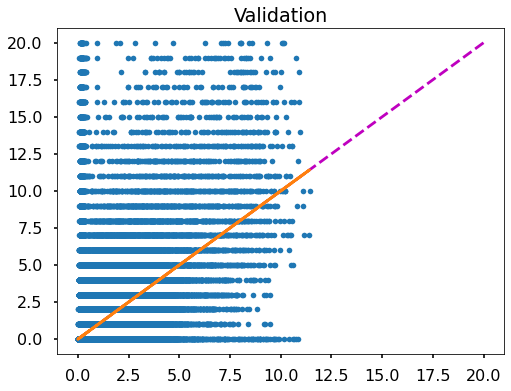

In [103]:
model_performance_sc_plot(combo_pred,y_validation,'Validation')

The result of ensembling method looks better than LSTM model. It might be that LSTM model isn't tuned well enough, or it might be that the ensemble method captures as much data feature as possible in the prediction since it combines linear, xgboost and random forest models.

In [104]:
submission_df = pd.DataFrame(test_sub.index.values,columns=['ID'])
submission_df['item_cnt_next_month'] = final_pred.clip(0.,20.)
submission_df.to_csv('ensemble_submission.csv',index=False)
submission_df.head(10)

,ID,item_cnt_next_month
0,0,0.992828
1,1,0.171638
2,2,1.436807
3,3,0.170615
4,4,0.171638
5,5,1.283601
6,6,0.944288
7,7,0.181322
8,8,1.806718
9,9,0.291392
